# MATH50003 (2024–25)
# Lab 7: IV.1 Polynomial Interpolation and Regression and IV.2 Differential Equations

We  explore polynomial interpolation and regression, and see that when
interpolating at an evenly spaced grid one can encounter issues with convergence.
This is overcome via regression, but we are left with the question of how to
solve the underlying least squares problems.

We also explore the reduction of differential equations to
banded linear systems via divided differences. When we get lower bidiagonal systems these can be solved
using forward substitution, whereas we will discuss the tridiagonal case later.

**Learning Outcomes**

Mathematical knowledge:

1. Vandermonde matrices and least squares.
2. Constructing interpolatory quadrature rules.
2. Issues with interpolation at evenly spaced points with functions with small radii of convergence.
3. Reduction of differential equations to bidiagonal or tridiagonal linear systems.
4. Two-point boundary value problems and their convergence rates.

Coding knowledge:

1. The error function `erfi` as provided by SpecialFunctions.jl.

We first load  packages we need including a couple new ones:

In [1]:
# LinearAlgebra contains routines for doing linear algebra
using LinearAlgebra, Plots, Test

**Remark** One should normally not need to implement methods for solving differential equations
oneself as there are packages available, including the high-performance
 Julia package  [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl). Moreover Forward and Backward
Euler are only the first baby steps to a wide range of time-steppers, with Runge–Kutta being
one of the most successful.
For example, in practice we can solve
a simple differential equation like a pendulum $u'' = -\sin u$ can be solved
as follows (writing at a system $u' = v, v' = -\sin u$):

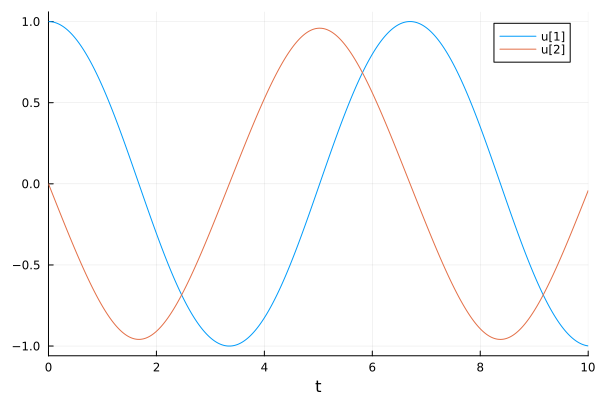

In [2]:
using DifferentialEquations, LinearAlgebra, Plots

u = solve(ODEProblem((u,_,x) -> [u[2], -sin(u[1])], [1,0], (0,10)))
plot(u)

However, even in these automated packages one has a choice of different methods with
different behaviour, so it is important to understand on a mathematical level what is happening under the hood.

## IV.1 Polynomial Interpolation and Regression

We now explore the practical usage of polynomial interpolation and regression.
In particular we will see that polynomial interpolation may fail as the number
of points becomes large.

### IV.1.1 Polynomial Interpolation

A quick-and-dirty way to to do interpolation is to invert the Vandermonde matrix.
That is, for
$$
p(x) = ∑_{k = 0}^{n-1} c_k x^k
$$
and $x_1, …, x_n ∈ ℝ$, we choose $c_k$ so that $p(x_j) = f(x_j)$ for
$j = 1, …, n$. We do so by creating the square Vandermonde matrix
$$
V := \begin{bmatrix} 1 & x_1 & ⋯ & x_1^{n-1} \\
                    ⋮ & ⋮ & ⋱ & ⋮ \\
                    1 & x_n & ⋯ & x_n^{n-1}
                    \end{bmatrix}.
$$
If the function samples are
$$
 𝐟 = \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_n) \end{bmatrix}
$$
then the coefficients of the interpolatory polynomial
$$
      𝐜 = \begin{bmatrix}
          c_0 \\ ⋮ \\ c_{n-1} \end{bmatrix}
$$
must satisfy $V 𝐜 = 𝐟$.  Thus inverting the Vandermonde matrix tells us the coefficients.

Here we see an example of this using `n` evenly spaced points:

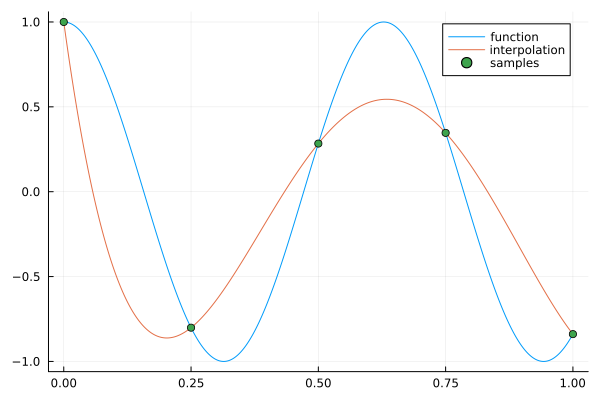

In [3]:
f = x -> cos(10x)
n = 5
𝐱 = range(0, 1; length=n) # evenly spaced points (BAD for interpolation)
V =  [𝐱[j]^k for j = 1:n, k = 0:n-1] # Vandermonde matrix, also can be written as x .^ (0:n)'
𝐟 = f.(𝐱) # evaluate f at x[k], equivalent to [f(x[k]) for k = 1:n]
𝐜 = V \ 𝐟 # invert the Vandermonde matrix and determine the coefficients
p = x -> dot(𝐜, x .^ (0:n-1)) # take a dot product with monomials x .^ 0:n-1 == [x^j for j=0:n-1]
@test p.(𝐱) ≈ V * 𝐜 # evaluating the polynomial on x is the same as applying V


𝐠 = range(0,1; length=1000) # plotting grid, sample a lot more than interpolation points

# To evaluate a polynomial on the plotting grid its faster to create the rectangular Vandermonde matrix associated with that grid:
V_g = [𝐠[j]^k for j = 1:length(𝐠), k = 0:n-1]

plot(𝐠, f.(𝐠); label="function")
plot!(𝐠, V_g*𝐜; label="interpolation")
scatter!(𝐱, f.(𝐱); label="samples")

Whether an interpolation is actually close to a function is a subtle question,
involving properties of the function, distribution of the sample points $x_1,…,x_n$,
and round-off error.
A classic example is:
$$
  f_M(x) = {1 \over M x^2 + 1}
$$
where the choice of $M$ can dictate whether interpolation at evenly spaced points converges.

-------

**Problem 1** Interpolate $1/(4x^2+1)$ and $1/(25x^2 + 1)$ at an evenly spaced grid of $n$
points, plotting the solution at a grid of $1000$ points. For $n = 50$ does your interpolation match
the true function?  Does increasing $n$ to 400 improve the accuracy? How about using `BigFloat`?
Hint: make sure to make your `range` be `BigFloat` valued, e.g., `range(big(-1), big(1); length=n)`.

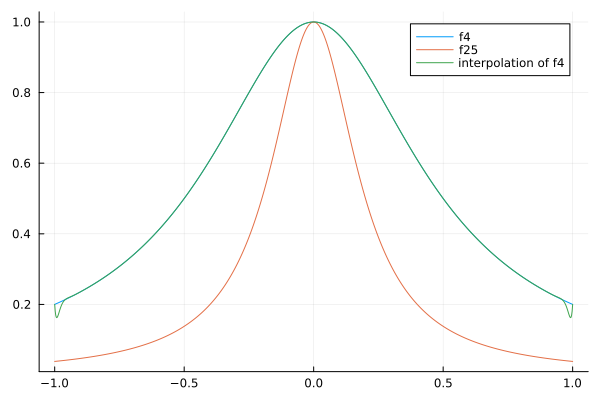

In [4]:
# TODO: interpolate 1/(10x^2 + 1) and 1/(25x^2 + 1) at $n$ evenly spaced points, plotting both solutions evaluated at
# the plotting grid with 1000 points, for $n = 50$ and $400$.
f4 = x -> 1 / (4x^2 + 1)
f25 = x -> 1 / (25x^2 + 1)
n1 = 50
n2 = 400
𝐱1 = range(big(-1),big(1); length=n1) # evenly spaced points (BAD for interpolation)
V1 =  [𝐱1[j]^k for j = 1:n1, k = 0:n1-1] # Vandermonde matrix, also can be written as x .^ (0:n)'
𝐟1 = f4.(𝐱1) # evaluate f at x[k], equivalent to [f(x[k]) for k = 1:n]
𝐜1 = V1 \ 𝐟1 # invert the Vandermonde matrix and determine the coefficients
p1 = x -> dot(𝐜1, x .^ (0:n1-1)) # take a dot product with monomials x .^ 0:n-1 == [x^j for j=0:n-1]
𝐱2 = range(big(-1),big(1); length=n2) # evenly spaced points (BAD for interpolation)
V2 =  [𝐱2[j]^k for j = 1:n2, k = 0:n2-1] # Vandermonde matrix, also can be written as x .^ (0:n)'
𝐟2 = f25.(𝐱2) # evaluate f at x[k], equivalent to [f(x[k]) for k = 1:n]
𝐜2 = V2 \ 𝐟2 # invert the Vandermonde matrix and determine the coefficients
p2 = x -> dot(𝐜2, x .^ (0:n2-1)) # take a dot product with monomials x .^ 0:n-1 == [x^j for j=0:n-1]
# @test p1.(𝐱) ≈ V1 * 𝐜1 # evaluating the polynomial on x is the same as applying V


𝐠 = range(big(-1),big(1); length=1000) # plotting grid, sample a lot more than interpolation points

# To evaluate a polynomial on the plotting grid its faster to create the rectangular Vandermonde matrix associated with that grid:
V1_g = [𝐠[j]^k for j = 1:length(𝐠), k = 0:n1-1]
V2_g = [𝐠[j]^k for j = 1:length(𝐠), k = 0:n2-1]

plot(𝐠, f4.(𝐠); label="f4")
plot!(𝐠, f25.(𝐠); label="f25")
plot!(𝐠, V1_g*𝐜1; label="interpolation of f4")
# plot!(𝐠, V2_g*𝐜2; label="interpolation of f25")
# scatter!(𝐱1, f4.(𝐱1); label="samples of f4")
# scatter!(𝐱2, f25.(𝐱2); label="samples of f25")


------

### IV.1.2 Interpolatory quadrature rules

An interpolatory quadrature rule consists of interpolating samples of a function and integrating
the polynomial exactly. In the notes we constructed such rules by integrating the Lagrange basis,
however, we can also compute the interpolatory polynomial by inverting the Vandermonde matrix.
Here we explore this construction.

**Problem 2(a)** Complete the following function that computes an interpolatory quadrature
$$
\int_0^1 f(x) {\rm d}x ≈ \int_0^1 p(x) {\rm d}x
$$
where $p(x)$ interpolates the data $𝐟 = [f_1,…,f_n]$ (given as a vector) at the given points $𝐱 = [x_1,…,x_n]$ (given as a vector).
Hint: it is much easier to solve a linear system involving the Vandermonde matrix than to use a Lagrange basis.

In [5]:
function interpolatoryquadrature(f::AbstractVector, x::AbstractVector)
    if length(f) ≠ length(x)
        error("lengths must match")
    end
    # TODO: Compute the coefficients of the interpolatory polynomial and integrate it exactly.
    # Vc = f
    n = length(x)
    V = [x[i]^k for i in 1:n, k in 0:n - 1]
    c = V \ f
    # p(x) = c1 + c2x + c3x^3 + ...
    # integral of p(x) = c1x + c2x^2/2 + c3x^3 + ...
    
    res = 0
    for i in 1:n
        res += c[i] / i
    end
    res
end

x = range(0, 1, 10)
@test interpolatoryquadrature(exp.(x), x) ≈ exp(1)-1

Test Passed

**Problem 2(b)**  Plot the error for the number of evenly spaced points $n = 2, 3, …, 100$ for approximating the integrals
$$
∫_0^1 \exp x {\rm d}x  = ℯ - 1, ∫_0^1 {{\rm d} x \over 25x^2 + 1} = {\rm arctan}(5)/5.
$$
How does the convergence behaviour compare with the Trapezium rule? Does the approximation appear to be stable?
Does using `BigFloat` improve the results? (Hint: `range(0,big(1),n)` will make a sequence of `BigFloat` points.)

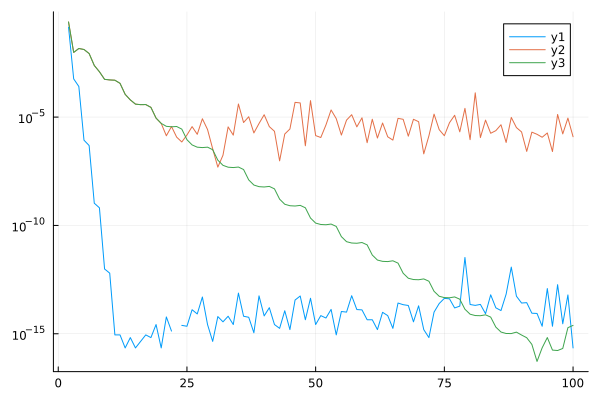

In [6]:
nanabs(x) = x == 0 ? NaN : abs(x)
# TODO: plot the errors for 2,…,100 evenly spaced points for approximating the integral of exp(x) and 1/(25x^2+1)
errors1 = [nanabs(interpolatoryquadrature(exp.(range(0, 1; length = i)), range(0, 1; length = i)) - exp(1) + 1) for i in 2:100]
errors2 = [nanabs(interpolatoryquadrature(1 ./ (25 .* (range(0, 1; length = i)) .^ 2 .+ 1), range(0, 1; length = i)) - atan(5)/5) for i in 2:100]
errors3 = [nanabs(interpolatoryquadrature(1 ./ (25 .* (range(big(0), big(1); length = i)) .^2 .+ 1), range(big(0), big(1); length = i)) - atan(big(5))/5) for i in 2:100]
plot(2:100, errors1, yscale=:log10)
plot!(2:100, errors2)
plot!(2:100, errors3)

**Problem 2(c)** Repeat the previous problem with the points $x_j = (\cos θ_j + 1)/2$ where $θ_j$ are $n$ evenly spaced points
between $0$ and $π$. How do the results compare with evenly spaced points?

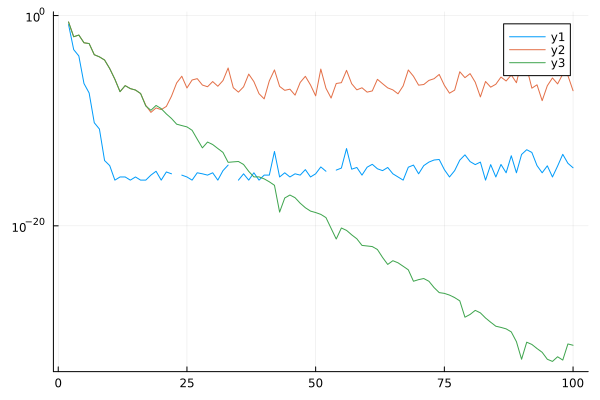

In [7]:
# TODO: plot the errors for 2,…,100 points that are cosines of evenly spaced points, shifted/scaled to be between 0 and 1.
# x = [(cos(i) + 1) / 2 for i in range(0, π, i)]
errors1 = [nanabs(interpolatoryquadrature(exp.([(cos(j) + 1) / 2 for j in range(0, π, i)]), [(cos(j) + 1) / 2 for j in range(0, π, i)]) - exp(1) + 1) for i in 2:100]
errors2 = [nanabs(interpolatoryquadrature(1 ./ (25 .* ([(cos(j) + 1) / 2 for j in range(0, π, i)]) .^ 2 .+ 1), [(cos(j) + 1) / 2 for j in range(0, π, i)]) - atan(5)/5) for i in 2:100]
errors3 = [nanabs(interpolatoryquadrature(1 ./ (25 .* ([(cos(j) + 1) / 2 for j in range(big(0), big(π), i)]) .^ 2 .+ 1), [(cos(j) + 1) / 2 for j in range(big(0), big(π), i)]) - atan(big(5))/5) for i in 2:100]
plot(2:100, errors1, yscale=:log10)
plot!(2:100, errors2)
plot!(2:100, errors3)

**Problem 3** Typically it's more convenient to compute the quadrature weights $w_j$ so that
$$
\int_0^1 f(x) {\rm d}x ≈ \int_0^1 p(x) {\rm d}x = ∑_{j=1}^n w_j f(x_j).
$$
Compute these weights by solving a linear system involving the transpose of the Vandermonde  matrix.

In [8]:
function interpolatoryweights(x::AbstractVector)
    # TODO: Construct the interpolatory quadrature weights as a vector by solving a linear system involving V'
    n = length(x)
    V = x .^ (0:n-1)'
    V' \ (1 ./ (1:n))
end

# We test on the example from the notes:
@test interpolatoryweights([0,1/4,1]) ≈ [-1/6, 8/9, 5/18]

Test Passed

------

### IV.1.3 Polynomial regression

To overcome issues with interpolation we will instead use regression: use more points than
the degree of the polynomial. As an example, suppose we want to fit noisy data by a quadratic
$$
p(x) = c₀ + c₁ x + c₂ x^2.
$$
That is, we want to choose $c₀,c₁,c₂$ at data samples $x_1, …, x_m$ so that the following is true:
$$
c₀ + c₁ x_j + c₂ x_j^2 ≈ f_j
$$
where $f_j$ are given by data. We can reinterpret this as a least squares problem: minimise the norm
$$
\left\| \begin{bmatrix} 1 & x_1 & x_1^2 \\ ⋮ & ⋮ & ⋮ \\ 1 & x_m & x_m^2 \end{bmatrix}
\begin{bmatrix} p₀ \\ p₁ \\ p₂ \end{bmatrix} - \begin{bmatrix} f_1 \\ ⋮ \\ f_m \end{bmatrix} \right \|
$$
When a matrix is rectangular `\` solves a least squares problem for us:

In [9]:
A = [1 3 4;
    1 2 3]

2×3 Matrix{Int64}:
 1  3  4
 1  2  3

In [10]:
m,n = 100,3

𝐱 = range(0,1; length=m) # 100 points
𝐟 = 2 .+ 𝐱 .+ 2𝐱.^2 .+ 0.1 .* randn.() # Noisy quadratic samples, built with broadcast notation.

V = 𝐱 .^ (0:2)'  # 100 x 3 Vandermonde matrix, equivalent to [ones(m) x x.^2]

𝐜 = V \ 𝐟 # coefficients are, very roughly, [2,1,2]

3-element Vector{Float64}:
 2.0848209119548144
 0.7496383626967342
 2.18607990839171

We can visualise the fit:

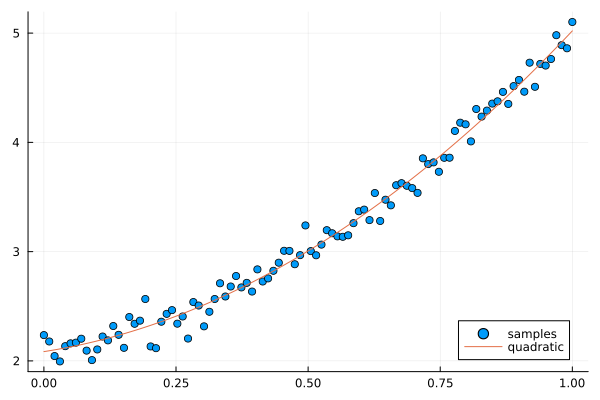

In [11]:
𝐠 =range(0, 1; length=1000)

p = x -> 𝐜[1] + 𝐜[2]x + 𝐜[3]x^2

scatter(𝐱, 𝐟; label="samples", legend=:bottomright)
plot!(𝐠, p.(𝐠); label="quadratic")




-----

**Problem 4** Repeat  Problem 1 but now using _least squares_: instead of interpolating,
use least squares on a large grid: choose the coefficients of a degree $(n-1)$ polynomial so that
$$
    \left\| \begin{bmatrix} p(x_1) \\ ⋮ \\ p(x_m) \end{bmatrix} - \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_m) \end{bmatrix} \right \|.
$$
is minimised, where $n = 50$ and $m = 500$.
Does this improve the accuracy near the endpoints? Do you think convergence for a least squares approximation
is dictated by the radius of convergence of the corresponding Taylor series?
Hint: use the rectangular Vandermonde matrix to setup the Least squares system. The solution will look extremely similar to Problem 1.

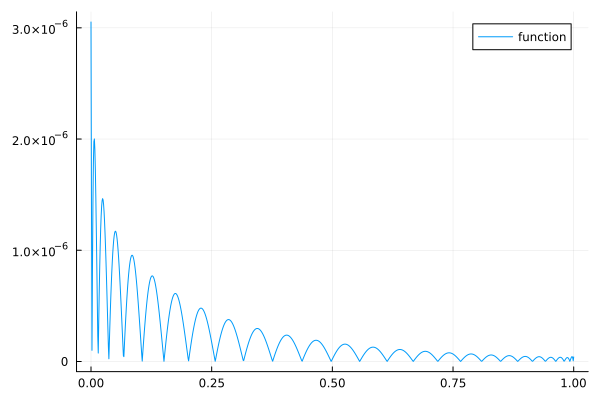

In [12]:
# TODO: approximate 1/(10x^2 + 1) and 1/(25x^2 + 1) using a least squares system.
n = 50
m = 500

𝐱 = range(0,1; length=m) # 100 points
f = x -> 1 / (25x^2 + 1)
𝐟 = 1 ./ (25𝐱 .^ 2 .+ 1)

V = 𝐱 .^ (0:n-1)'  # 100 x 3 Vandermonde matrix, equivalent to [ones(m) x x.^2]

𝐜 = V \ 𝐟 # coefficients are, very roughly, [2,1,2]

p = x -> dot(𝐜, x .^ (0:n-1)) # take a dot product with monomials x .^ 0:n-1 == [x^j for j=0:n-1]
# @test p1.(𝐱) ≈ V1 * 𝐜1 # evaluating the polynomial on x is the same as applying V


𝐠 = range(big(0),big(1); length=1000) # plotting grid, sample a lot more than interpolation points

# To evaluate a polynomial on the plotting grid its faster to create the rectangular Vandermonde matrix associated with that grid:
V_g = [𝐠[j]^k for j = 1:length(𝐠), k = 0:n-1]

plot(𝐠, nanabs.(V_g*𝐜 - f.(𝐠)); label="function")
# plot!(𝐠, V_g*𝐜; label="interpolation")
# plot!(𝐠, V2_g*𝐜2; label="interpolation of f25")
# scatter!(𝐱1, f4.(𝐱1); label="samples of f4")
# scatter!(𝐱2, f25.(𝐱2); label="samples of f25")

## IV.2 Differential Equations via Finite Differences

We now turn to an important application of banded linear algebra:
approximating solutions to linear differential equations. We will focus on first and second order
but the techniques generalise beyond this, to vector problems, nonlinear differential equations, and partial differential equations.
In particular we explore _finite difference_ approximations which use divided differences to replace derivatives.
These are the most basic type of numerical method and many powerful alternatives
exist, including Finite Element Methods and spectral methods.

### IV.2.1 Indefinite integration

We can use the right-sided divided difference to approximate derivatives.  Let's do an example of integrating $\cos x$ by discretising the ODE
$$
 u(0) = c, \qquad u'(x) = f(x)
$$
and see if our method matches
the true answer of $\sin x$. Recall from the notes that this equation can be approximated by $u_k$ solving the bidiagonal linear system
$$
\begin{bmatrix}
    1 \\
    -1/h & 1/h \\
    & ⋱ & ⋱ \\
    && -1/h & 1/h \end{bmatrix} \begin{bmatrix}u_0\\u_1\\⋮\\u_n\end{bmatrix} = \begin{bmatrix}c\\ f(x_0)\\ ⋮ \\ f(x_{n-1})\end{bmatrix}.
$$
We can construct the bidiagonal matrix as follows:

In [13]:
n = 10
x = range(0, 1; length=n+1) # makes an n+1 point evenly spaced grid
h = step(x) # equivalent to 1/n
L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)

11×11 Bidiagonal{Float64, Vector{Float64}}:
   1.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
 -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0    ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0  10.0

We can use this bidiagonal matrix along with `\` to solve the
system via forward substitution:

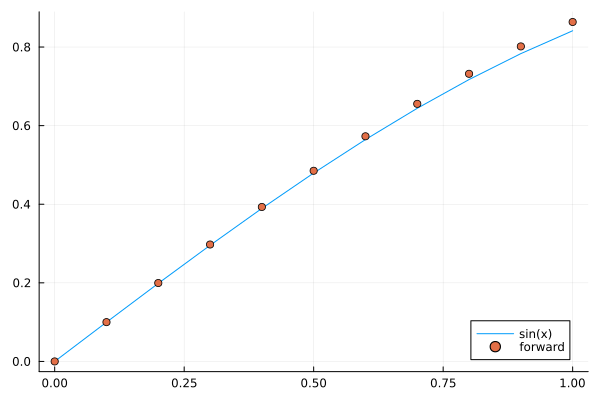

In [14]:
c = 0 # u(0) = 0
f = x -> cos(x)

𝐟 = f.(x[1:end-1]) # evaluate f at all but the last point
𝐛 = [c; 𝐟]
𝐮 = L \ 𝐛 # integrate using forward-differences

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, 𝐮; label="forward")

 We can estimate how fast it converges by measuring
the ∞-norm error (using $\| 𝐱 \|_∞ := \max |x_k|$ which
is implemented as `norm(x,Inf)`):

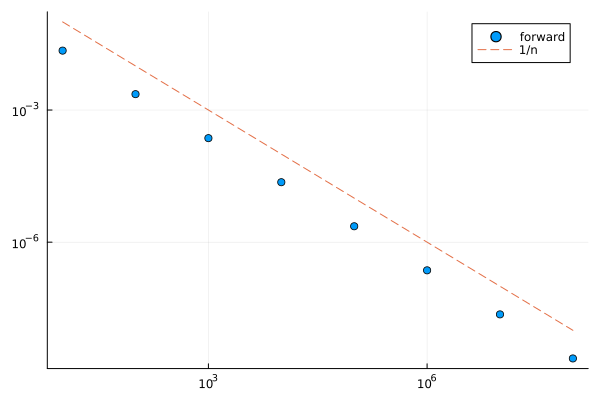

In [15]:
# Error from indefinite integration with c and f
function forward_err(u, c, f, n)
    x = range(0, 1; length = n+1)
    h = step(x) # equivalent to 1/n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
    𝐮 = L\ [c; f.(x[1:end-1])]
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf) # measure ∞-norm error
end


ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, forward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="forward")
plot!(ns, ns .^ (-1); label="1/n", linestyle=:dash)

We see that the method converges linearly (like $O(n^{-1})$).

------

**Problem 5(a)** In the problem sheet we derived Backward Euler using the left-sided divided difference
$$
  u'(x) ≈ {u(x) - u(x-h) \over h}
$$
Implement Backward Euler to approximate
indefinite-integration. How does the error compare to forward
for $f(x) = \cos x$ on the interval $[0,1]$?
Use the method to approximate the indefinite intergral of
$$
\exp(\exp x \cos x + \sin x)
$$
to 3 digits.

In [16]:
# TODO: Implement Backward Euler by constructing a lower bidiagonal linear system.
function backwardEuler(c, f, n)
    x = range(0, 1, length = n + 1)
    h = 1.0 / n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
    𝐮 = L \ [c; f.(x[2:end])]
end

function backwardEulerError(u, c, f, n)
    x = range(0, 1, length = n + 1)
    𝐮 = backwardEuler(c, f, n)
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf) # measure ∞-norm error
end



ns = 10 .^ (1:8) # solve up to n = 10 million
f = x -> exp(exp(x) * cos(x) + sin(x))
n = 100000
backwardEuler(0, f, n)

100001-element Vector{Float64}:
 0.0
 2.7183361946392736e-5
 5.436726756546101e-5
 8.155171686807822e-5
 0.00010873670986511792
 0.00013592224656745376
 0.00016310832698595955
 0.00019029495113150925
 0.0002174821190149769
 0.00024466983064723674
 0.00027185808603916314
 0.00029904688520163055
 0.00032623622814551364
 ⋮
 6.794260550282281
 6.7943613139474985
 6.79446207733275
 6.794562840437982
 6.79466360326314
 6.794764365808171
 6.79486512807302
 6.794965890057635
 6.795066651761961
 6.795167413185945
 6.795268174329532
 6.79536893519267

**Problem 5(b)** Implement indefinite-integration
where we impose the equation on the midpoints $x̃_1,…,x̃_n$ defined as
$$
x̃_j = {x_{j+1} + x_j \over 2} = a + (j-1/2)h
$$
using the central difference formula
$$
u'(x̃_j) ≈ {u(x_j) - u(x_{j-1}) \over h}
$$
By plotting the errors show that this method converges at
a faster rate than Forward or Backward Euler for $f(x) = \cos x$ on the interval $[0,1]$.

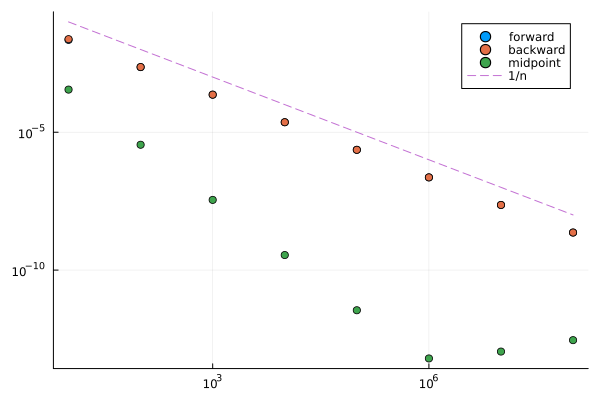

In [17]:
# TODO: Discretise at midpoints rather than our grid. The solution is still approximated on the original grid.
function midpointEuler(c, f, n)
    x = range(0, 1, length = n + 1)
    midpoints = zeros(n)
    for i in 1:n
        midpoints[i] = (x[i + 1] + x[i]) / 2
    end
    h = 1.0 / n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
    𝐮 = L \ [c; f.(midpoints[1:end])]
end

function midpointEulerError(u, c, f, n)
    x = range(0, 1, length = n + 1)
    𝐮 = midpointEuler(c, f, n)
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf) # measure ∞-norm error
end

ns = 10 .^ (1:8) # solve up to n = 10 million
f = x -> cos(x)
scatter(ns, forward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="forward")
scatter!(ns, [backwardEulerError(sin, 0, f, i) for i in ns]; xscale=:log10, yscale=:log10, label="backward")
scatter!(ns, [midpointEulerError.(sin, 0, f, i) for i in ns]; xscale=:log10, yscale=:log10, label="midpoint")
plot!(ns, ns .^ (-1); label="1/n", linestyle=:dash)
    

----

### IV.2.2 Forward Euler

We now adapt the approach for more general ODEs of the form
$$
  u'(x) + ω(x)u(x) = f(x), u(0) = c.
$$
We now have the system:
$$
\underbrace{\begin{bmatrix}
1 \\
ω(x_0)-1/h & 1/h \\
& ⋱ & ⋱ \\
&& ω(x_{n-1})-1/h & 1/h \end{bmatrix}}_L \underbrace{\begin{bmatrix}u_0 \\ u_1 \\ ⋮ \\ u_n\end{bmatrix} }_{𝐮} = \begin{bmatrix} c \\ f(x_0) \\ ⋮ \\ f(x_{n-1}) \end{bmatrix}
$$
Consider the simple example:
 $$
 u(0) = 1, u' + x u = {\rm e}^x
 $$
 which has an exact solution in terms of a special error function
 (which I determined using Mathematica).

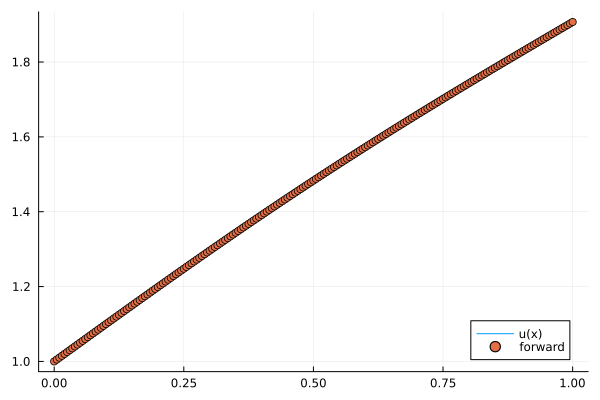

In [18]:
using SpecialFunctions
c = 1
ω = x -> x
n = 200
x = range(0, 1; length=n+1)
# exact solution, found in Mathematica
u = x -> -(1/2)*exp(-(1+x^2)/2)*(-2sqrt(ℯ) + sqrt(2π)erfi(1/sqrt(2)) - sqrt(2π)erfi((1 + x)/sqrt(2)))

h = step(x)
L = Bidiagonal([1; fill(1/h, n)], ω.(x[1:end-1]) .- 1/h, :L)

𝐛 = [c; exp.(x[1:end-1])]
𝐮 = L \ 𝐛

plot(x, u.(x); label="u(x)", legend=:bottomright)
scatter!(x, 𝐮; label="forward")

# We see that it is converging to the true result.

----

**Problem  6** Implement backward Euler for solving:
$$
\begin{align*}
u(0) &= 1, u'(t) - \cos(t) u(t) = t
\end{align*}
$$
on the interval $[0,1]$. Approximate $u(1)$ to three digits accuracy.

In [44]:
# TODO: Implement backward Euler for the case with a variable coefficient.

n = 10000
c = 1
f = x -> x
w = x -> -cos(x)

x = range(0, 1, length = n + 1)
h = 1.0 / n
L = Bidiagonal([1; fill(1/h, n)], w.(x[1:end-1]) .- 1/h, :L)
𝐮 = (L \ [c; f.(x[2:end])])[n + 1]


2.967198157362797

-----

### IV.2.3 Poisson equation

We now consider the Poisson equation with Dirichlet
boundary conditions. In particular consider a case where
we know the true answer: if $u(x) = \cos x^2$ then it solves the ODE:
$$
\begin{align*}
u(0) = \underbrace{1}_c \\
u''(x) = \underbrace{-4x^2 \cos(x^2) - 2\sin(x^2)}_{f(x)} \\
u(1) = \underbrace{\cos 1}_d
\end{align*}
$$
We approximate it by the solution to the tridiagonal system:
$$
\underbrace{\begin{bmatrix}
    1 \\
    1/h^2 & -2/h^2 & 1/h \\
    & ⋱ & ⋱ & ⋱ \\
   && 1/h^2 & -2/h^2 & 1/h \\
   &&&& 1 \end{bmatrix}}_A \underbrace{\begin{bmatrix}u_0\\u_1\\⋮\\u_n\end{bmatrix} }_{𝐮} = \underbrace{\begin{bmatrix}c\\ f(x_0)\\ f(x_1)\\ ⋮ \\ f(x_{n-1})\\ d\end{bmatrix} }_{𝐛}
$$
We first construct the matrix $A$ using `Tridiagonal`:

In [45]:
n = 20
x = range(0, 1; length = n + 1)
h = step(x)
A = Tridiagonal([fill(1/h^2, n-1); 0],
                [1; fill(-2/h^2, n-1); 1],
                [0; fill(1/h^2, n-1)])

21×21 Tridiagonal{Float64, Vector{Float64}}:
   1.0     0.0      ⋅       ⋅       ⋅   …      ⋅       ⋅       ⋅      ⋅ 
 400.0  -800.0   400.0      ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅    400.0  -800.0   400.0      ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅    400.0  -800.0   400.0         ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅    400.0  -800.0         ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅    400.0  …      ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅   …      ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅ 

Thus we get an approximation to our (known) solution:

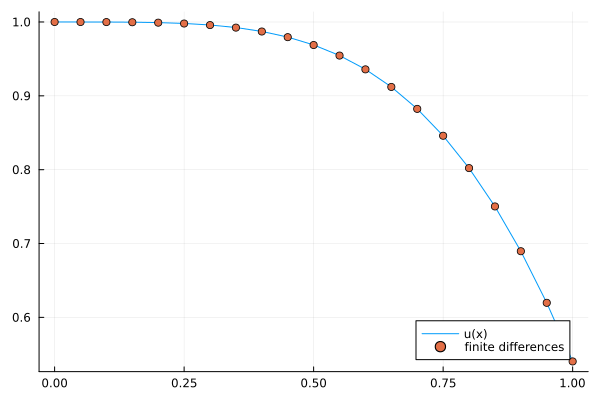

In [46]:
u = x -> cos(x^2)
f = x -> -4x^2*cos(x^2) - 2sin(x^2)
𝐛 =  [1; f.(x[2:end-1]); cos(1)]
𝐮 = A \ 𝐛
plot(x, u.(x); label="u(x)", legend=:bottomright)
scatter!(x, 𝐮; label="finite differences")

-----

**Problem 7(a)** Estimate the rate of convergence in the ∞-norm using the previous example with an increasing number of grid points.

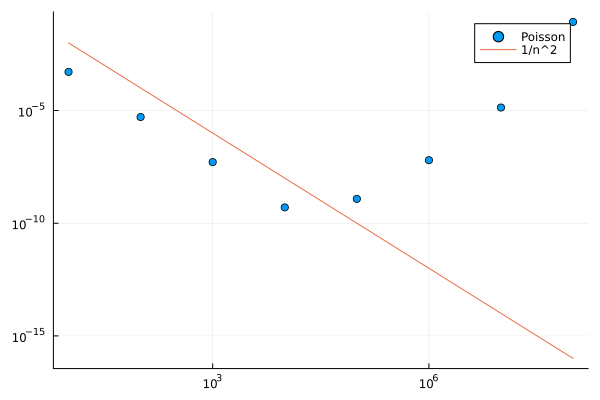

In [58]:
# TODO: Plot the ∞-norm error and estimate the convergence rate.

function PoissonEq(n)
    x = range(0, 1; length = n + 1)
    h = step(x)
    A = Tridiagonal([fill(1/h^2, n-1); 0],
                    [1; fill(-2/h^2, n-1); 1],
                    [0; fill(1/h^2, n-1)])
    u = x -> cos(x^2)
    f = x -> -4x^2*cos(x^2) - 2sin(x^2)
    𝐛 =  [1; f.(x[2:end-1]); cos(1)]
    𝐮 = A \ 𝐛
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf)
end
ns = 10 .^ (1:8) # solve up to n = 10 million
f = x -> cos(x)
scatter(ns, PoissonEq.(ns); xscale=:log10, yscale=:log10, label="Poisson")
plot!(ns, ns .^ -2; label = "1/n^2")

**Problem 7(b)** Construct a finite-difference approximation to the
forced Helmholtz equation
$$
\begin{align*}
u(0) &= 0 \\
u(1) &= 0 \\
u'' + k^2 u &= {\rm e}^x
\end{align*}
$$
and find an $n$ such  the error is less than $10^{-4}$ when compared
with the true solution for $k=10$:
$$
u(x) = (-\cos(k x) + {\rm e}^x \cos(k x)^2 + \cot(k) \sin(k x) - {\rm e} \cos(k) \cot(k) \sin(k x) - {\rm e} \sin(k) \sin(k x) + {\rm e}^x \sin(k x)^2)/(1 + k^2)
$$

In [80]:
# TODO: Generalise the second-order finite differences to allow for a $k^2 u$ term.
function HelmholtzEq(n, k)
    x = range(0, 1; length = n + 1)
    h = step(x)
    A = Tridiagonal([fill(1/h^2, n-1); 0],
                    [1; fill(-2/h^2 + k^2, n-1); 1],
                    [0; fill(1/h^2, n-1)])
    u = x -> (-cos(k*x) + exp(x)*(cos(k*x))^2 + cot(k)*sin(k*x) -  exp(1)*cos(k)*cot(k)*sin(k*x) - exp(1)*sin(k)*sin(k*x) + exp(x)sin(k*x)^2)/(1 + k^2)
    f = x -> exp(x)
    𝐛 =  [0; f.(x[2:end-1]); 0]
    𝐮 = A \ 𝐛
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf)
end


n = 1000
HelmholtzEq(n, 10)

4.791307154666802e-6

**Problem 8(a)** Consider the Helmholtz equations
$$
\begin{align*}
u(0) &= 0 \\
u(1) &= 0 \\
u'' + k^2 u &= {\rm e}^x
\end{align*}
$$
discretised with finite-differences to result in a tridiagonal system.
Use the `lu` function without pivoting to
compute the LU factorization of the tridiagonal matrix. What sparsity structure
do you observe in `L` and `U`? Does this structure depend on $n$ or $k$?

In [97]:


# TODO: Apply lu to the discretisation for Helmholtz derived in the last lab and investigate its structure.
function HelmholtzLU(n, k)
    x = range(0, 1; length = n + 1)
    h = step(x)
    A = Tridiagonal([fill(1/h^2, n-1); 0],
                    [1; fill(-2/h^2 + k^2, n-1); 1],
                    [0; fill(1/h^2, n-1)])
    # u = x -> (-cos(k*x) + exp(x)*(cos(k*x))^2 + cot(k)*sin(k*x) -  exp(1)*cos(k)*cot(k)*sin(k*x) - exp(1)*sin(k)*sin(k*x) + exp(x)sin(k*x)^2)/(1 + k^2)
    # f = x -> exp(x)
    # 𝐛 =  [0; f.(x[2:end-1]); 0]
    # 𝐮 = A \ 𝐛
    # errs = 𝐮 - u.(x) # compare numerics with "true" result
    l, U = lu(A, NoPivot())
    
end

HelmholtzLU(6, 6)

LoadError: SingularException(3)

**Problem 8(b)** Repeat Problem 8(a) but with a PLU factorisation.
Are $L$ and $U$ still banded?

In [100]:
# TODO: Check sparsity of PLU factorisation
function HelmholtzPLU(n, k)
    x = range(0, 1; length = n + 1)
    h = step(x)
    A = Tridiagonal([fill(1/h^2, n-1); 0],
                    [1; fill(-2/h^2 + k^2, n-1); 1],
                    [0; fill(1/h^2, n-1)])
    # u = x -> (-cos(k*x) + exp(x)*(cos(k*x))^2 + cot(k)*sin(k*x) -  exp(1)*cos(k)*cot(k)*sin(k*x) - exp(1)*sin(k)*sin(k*x) + exp(x)sin(k*x)^2)/(1 + k^2)
    # f = x -> exp(x)
    # 𝐛 =  [0; f.(x[2:end-1]); 0]
    # 𝐮 = A \ 𝐛
    # errs = 𝐮 - u.(x) # compare numerics with "true" result
    l, U = lu(A)
    
end

HelmholtzPLU(20, 6)

LU{Float64, Tridiagonal{Float64, Vector{Float64}}, Vector{Int64}}
L factor:
21×21 Matrix{Float64}:
 1.0     0.0       0.0         …   0.0         0.0          0.0  0.0
 0.0     1.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       1.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0         …   0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0         …   0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0     0.0       0.0             0.0         0.0          0.0  0.0
 0.0

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*